# Notebook to view how to load and convert a model from TensorFlow 2 Detection Model Zoo to .tflite and make inference.

In [1]:
!pip install -q tf-nightly

     |████████████████████████████████| 390.1MB 42kB/s 
     |████████████████████████████████| 460kB 49.0MB/s 
     |████████████████████████████████| 10.2MB 176kB/s 


In [2]:
import tensorflow as tf 
print(tf.__version__)

2.4.0-dev20200916


In [3]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 44499 (delta 47), reused 43 (delta 2), pack-reused 44411
Receiving objects: 100% (44499/44499), 550.54 MiB | 15.79 MiB/s, done.
Resolving deltas: 100% (30379/30379), done.


In [4]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1577686 sha256=35b5e327c62cd310ec8a72248369c16611c72ad346e4f6571f953681a198ab02
  Stored in directory: /tmp/pip-ephem-wheel-cache-nrm96xsr/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.0-cp36-none-any.whl size=43735 sha256=e6014b1bf8a98a4528f9f432603aa4054858482e278cbaba0515470310e6c37c
  Stored in directory: /root/.cache/pip/wheels/3f/15/cd/fe4ec8b88c130393464703ee8111e2cddebdc40e1b59ea85e9
  Created wheel for dill: filename=dill-0.3.1.1-cp36-none-any.whl size=78532 sha256=1b1ce9b852104fe2ef3dbcd73bdcabe3c259ff0e069edfdf47d3633d304230c2
  Stored in directory: /root/.cache/pip/wheels/59/b1/91/f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
  Created wheel for oauth2client: filename=oauth2client-3.0.0-cp36-none-any.whl size=106382 sha256=37be1984928a1232a363cb74b678c5de75c7068ff

ERROR: pydrive 1.3.1 has requirement oauth2client>=4.0.0, but you'll have oauth2client 3.0.0 which is incompatible.
ERROR: multiprocess 0.70.10 has requirement dill>=0.3.2, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.24.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.24.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1; python_version >= "3.0", but you'll have avro-python3 1.10.0 which is incompatible.


You can ignore the compatibility errors.



In [5]:
# Other imports
import matplotlib
import matplotlib.pyplot as plt

import cv2
import time
import numpy as np

from PIL import Image

## Export a TFLite compatible model graph

You can load models, checkpoints and pictures from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Or download directly from [TensorFlow 2 Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). Here we use an SSD model

In [6]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz

--2020-09-17 05:46:26--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.97.128, 2404:6800:4008:c00::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.97.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20518283 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.57M  14.2MB/s    in 1.4s    

2020-09-17 05:46:29 (14.2 MB/s) - ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’ saved [20518283/20518283]



In [7]:
!tar -xvf '/content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz'

ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0.index
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/pipeline.config
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/saved_model/
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/saved_model/saved_model.pb
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/saved_model/variables/
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/saved_model/variables/variables.index


In [8]:
!python /content/models/research/object_detection/export_tflite_graph_tf2.py \
    --trained_checkpoint_dir /content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint \
    --output_directory `pwd` \
    --pipeline_config_path /content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/pipeline.config

2020-09-17 05:47:31.725775: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-09-17 05:47:31.725824: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2020-09-17 05:47:34.377709: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-09-17 05:47:34.399986: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-09-17 05:47:34.448386: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-09-17 05:47:34.448463: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not

In [9]:
!ls -lh /content/saved_model/

total 7.6M
drwxr-xr-x 2 root root 4.0K Sep 17 05:48 assets
-rw-r--r-- 1 root root 7.6M Sep 17 05:48 saved_model.pb
drwxr-xr-x 2 root root 4.0K Sep 17 05:48 variables


## Convert to TensorFlow Lite

### Without quantization

In [10]:
# Convert the model to TF lite
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model/')
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Serialize the model
open('mobilenet.tflite', 'wb').write(tflite_model)
interpreter = tf.lite.Interpreter('/content/mobilenet.tflite')
#interpreter.allocate_tensors()

#input_details = interpreter.get_output_details()
print(interpreter.get_input_details())
print(interpreter.get_output_details())

[{'name': 'serving_default_input:0', 'index': 0, 'shape': array([  1, 640, 640,   3], dtype=int32), 'shape_signature': array([  1, 640, 640,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:3', 'index': 333, 'shape': array([], dtype=int32), 'shape_signature': array([], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:2', 'index': 334, 'shape': array([], dtype=int32), 'shape_signature': array([], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([

For this purpose, we will be using the dynamic-range post-training quantization to keep things simple. You can check out all the post-training quantization recipes available with TFLite [here](https://www.tensorflow.org/lite/performance/post_training_quantization). 

In [ ]:
# Convert the model to TF lite
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model/')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Serialize the model
open('mobilenet_quantized.tflite', 'wb').write(tflite_model)
interpreter = tf.lite.Interpreter('/content/mobilenet_quantized.tflite')
#interpreter.allocate_tensors()

#input_details = interpreter.get_output_details()
print(interpreter.get_input_details())
print(interpreter.get_output_details())

[{'name': 'serving_default_input:0', 'index': 0, 'shape': array([  1, 640, 640,   3], dtype=int32), 'shape_signature': array([  1, 640, 640,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:3', 'index': 333, 'shape': array([], dtype=int32), 'shape_signature': array([], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:2', 'index': 334, 'shape': array([], dtype=int32), 'shape_signature': array([], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([

In [11]:
!ls -lh mobilenet.tflite

-rw-r--r-- 1 root root 12M Sep 17 05:48 mobilenet.tflite


In [ ]:
!ls -lh mobilenet_quantized.tflite

-rw-r--r-- 1 root root 4.1M Sep 15 06:03 mobilenet_quantized.tflite


## Run inference with the TFLite model

In [12]:
#@title TFLite Interpreter and detection utils 
#@markdown Sourced from [here](https://github.com/tensorflow/examples/blob/master/lite/examples/object_detection/raspberry_pi/detect_picamera.py).

def set_input_tensor(interpreter, image):
  """Sets the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Returns the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all output details
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
          'bounding_box': boxes[i],
          'class_id': classes[i],
          'score': scores[i]
      }
      results.append(result)
  return results

def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all output details
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
          'bounding_box': boxes[i],
          'class_id': classes[i],
          'score': scores[i]
      }
      results.append(result)
  return results

In [13]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/mobilenet.tflite")
interpreter.allocate_tensors()
_, HEIGHT, WIDTH, _ = interpreter.get_input_details()[0]['shape']
print(f"Height and width accepted by the model: {HEIGHT, WIDTH}")

Height and width accepted by the model: (640, 640)


In [14]:
#@title Image preprocessing utils
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    original_image = img
    resized_img = tf.image.resize(img, (HEIGHT, WIDTH))
    resized_img = resized_img[tf.newaxis, :]
    return resized_img, original_image

In [ ]:
#@title Print coco labels in dictionary form
f = open('/content/coco-labels-paper.txt', 'r')
answer = {}
for line in enumerate(f):
    k, v = line
    answer[k] = v.strip()

print(answer)
print("{" + "\n".join("{!r}: {!r},".format(k, v) for k, v in answer.items()) + "}")
f.close()

In [15]:
#@title Define the label dictionary and color map
LABEL_DICT = {0: 'person',
1: 'bicycle',
2: 'car',
3: 'motorcycle',
4: 'airplane',
5: 'bus',
6: 'train',
7: 'truck',
8: 'boat',
9: 'traffic light',
10: 'fire hydrant',
11: 'street sign',
12: 'stop sign',
13: 'parking meter',
14: 'bench',
15: 'bird',
16: 'cat',
17: 'dog',
18: 'horse',
19: 'sheep',
20: 'cow',
21: 'elephant',
22: 'bear',
23: 'zebra',
24: 'giraffe',
25: 'hat',
26: 'backpack',
27: 'umbrella',
28: 'shoe',
29: 'eye glasses',
30: 'handbag',
31: 'tie',
32: 'suitcase',
33: 'frisbee',
34: 'skis',
35: 'snowboard',
36: 'sports ball',
37: 'kite',
38: 'baseball bat',
39: 'baseball glove',
40: 'skateboard',
41: 'surfboard',
42: 'tennis racket',
43: 'bottle',
44: 'plate',
45: 'wine glass',
46: 'cup',
47: 'fork',
48: 'knife',
49: 'spoon',
50: 'bowl',
51: 'banana',
52: 'apple',
53: 'sandwich',
54: 'orange',
55: 'broccoli',
56: 'carrot',
57: 'hot dog',
58: 'pizza',
59: 'donut',
60: 'cake',
61: 'chair',
62: 'couch',
63: 'potted plant',
64: 'bed',
65: 'mirror',
66: 'dining table',
67: 'window',
68: 'desk',
69: 'toilet',
70: 'door',
71: 'tv',
72: 'laptop',
73: 'mouse',
74: 'remote',
75: 'keyboard',
76: 'cell phone',
77: 'microwave',
78: 'oven',
79: 'toaster',
80: 'sink',
81: 'refrigerator',
82: 'blender',
83: 'book',
84: 'clock',
85: 'vase',
86: 'scissors',
87: 'teddy bear',
88: 'hair drier',
89: 'toothbrush',
90: 'hair brush'}

COLORS = np.random.randint(0, 255, size=(len(LABEL_DICT), 3), 
                            dtype="uint8")

In [16]:
#@title Inference utils
def display_results(image_path, threshold=0.3):
    # Load the input image and preprocess it
    preprocessed_image, original_image = preprocess_image(image_path)
    print(preprocessed_image.shape, original_image.shape)

    # =============Perform inference=====================
    start_time = time.monotonic()
    results = detect_objects(interpreter, preprocessed_image, threshold=threshold)
    print(f"Elapsed time: {(time.monotonic() - start_time)*1000} miliseconds")

    # =============Display the results====================
    original_numpy = original_image.numpy()
    for obj in results:
        # Convert the bounding box figures from relative coordinates
        # to absolute coordinates based on the original resolution
        ymin, xmin, ymax, xmax = obj['bounding_box']
        xmin = int(xmin * original_numpy.shape[1])
        xmax = int(xmax * original_numpy.shape[1])
        ymin = int(ymin * original_numpy.shape[0])
        ymax = int(ymax * original_numpy.shape[0])

        # Grab the class index for the current iteration
        idx = int(obj['class_id'])
        # Skip the background
        if idx >= len(LABEL_DICT):
            continue

        # draw the bounding box and label on the image
        color = [int(c) for c in COLORS[idx]]
        cv2.rectangle(original_numpy, (xmin, ymin), (xmax, ymax), 
                    color, 2)
        y = ymin - 15 if ymin - 15 > 15 else ymin + 15
        label = "{}: {:.2f}%".format(LABEL_DICT[obj['class_id']],
            obj['score'] * 100)
        cv2.putText(original_numpy, label, (xmin, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # return the final ima
    original_int = (original_numpy * 255).astype(np.uint8)
    return original_int

(1, 640, 640, 3) (364, 640, 3)
Elapsed time: 444.1769469999599 miliseconds


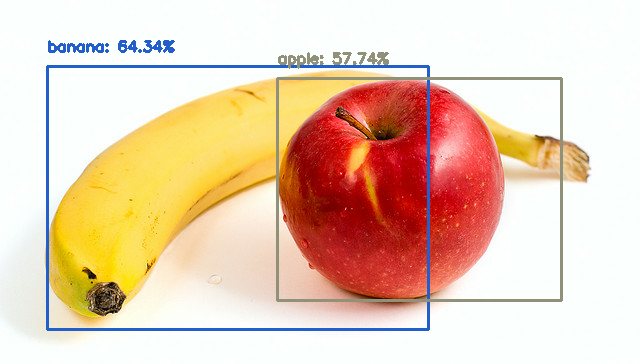

In [17]:
resultant_image = display_results('apples-bananas.jpg')
Image.fromarray(resultant_image)